# making movies of the Sun

The Helioseismic and Magnetic Imager (HMI) on the Solar Dynamics Observatory takes full-disk continuum intensity, doppler velocity, and magnetic field maps of the solar surface. Here, we make a movie of the radial component of the vector magnetic field using a data product called [HMI Space-weather Active Region Patches](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) or SHARPs. SHARPs contain partial-disk patches of the continuum intensity, doppler velocity, and magnetic field maps. These patches encapsulate automatically-detected active regions that are tracked throughout their lifetime.

We can make movies in two different ways: 

- Use JSOC Exportdata to build a movie directly (but you are limited to its formats and colortables); see the ipython notebook within this same directory called `plot_swx_d3.ipynb` for an example.
- Make a movie from image data to create a customized movie of any size, colortable, or format. An example of this process is outlined below.

First, we import some modules:

In [1]:
import json, urllib, numpy as np, matplotlib, matplotlib.pylab as plt, requests
import matplotlib.animation as manimation
import drms
from datetime import datetime as dt_obj
from matplotlib.dates import *
import matplotlib.dates as mdates
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.animation as manimation
from sunpy.visualization import imageanimator
import sunpy

In [2]:
sunpy.__version__

'0.9.3'

We query the JSOC database, where all the SDO data are stored, using the JSON API to retrieve both keywords and the location of the SHARP image files. The [astropy](http://docs.astropy.org/en/stable/io/fits/index.html) library's  `fits.open()` call downloads the data. Here, we're querying for the $B_z$ component of the vector magnetic field (note the variable passed to the `Seg` keyword in the url below), although we can easily query for other data products (see table A.7 in [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) for segment name information). <br>

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.

In [3]:
import drms
c = drms.Client()

Then we query for the appropriate DRMS series for the keywords and segments of our choice:

In [4]:
keys, segments = c.query('hmi.sharp_cea_720s[7117][2017.09.03_00:00_TAI-2017.09.06_00:00_TAI@4h]', key='NOAA_ARS, T_REC, USFLUX, ERRVF', seg='Br, conf_disambig')

To convert the keyword `T_REC` into a datetime object, we can use the function below.

In [5]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [6]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

### test 1: 2D data

In [7]:
nz = (len(segments))

In [8]:
print(nz)

16


In [9]:
ims = []
for i in range(nz):
    url = 'http://jsoc.stanford.edu' + segments.Br[i]
    photosphere_image = fits.open(url)                  # download the data
    ims.append(photosphere_image[1].data)

In [10]:
data_cube = np.stack((ims))

In [11]:
# generate index labels

# generate x labels
xmin = 0
xmax = data_cube.shape[-1]
xlabels = np.arange(data_cube.shape[-1])

# generate y labels
ymin = 0
ymax = data_cube.shape[-2]
ylabels = np.arange(data_cube.shape[-2])

# generate z labels
zmin = 0
zmax = data_cube.shape[-3]
zlabels = np.arange(data_cube.shape[-3])

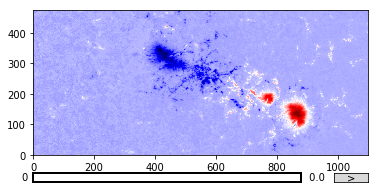

In [12]:
outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[zlabels, (ymin, ymax), (xmin, xmax)], cmap='seismic_r')

In [13]:
plot_x_axis_index = -1
plot_y_axis_index = -2

The shape of the x-axis values array can take two forms.
* First, it can equal the the length of the data array along the dimension corresponding to the x-axis, i.e.
`len(axis_ranges[plot_axis_index]) == len(data[plot_axis_index])`

In this scenario the same x-axis values are used in every frame of the animation.


In [14]:
# try different dtypes
data_cube.shape

print(16*476*1098.)
xdatacube = np.arange(8362368).reshape(16, 476, 1098)

8362368.0


In [15]:
xdatacube[:,0,0]

array([      0,  522648, 1045296, 1567944, 2090592, 2613240, 3135888,
       3658536, 4181184, 4703832, 5226480, 5749128, 6271776, 6794424,
       7317072, 7839720])

In [16]:
data_cube.shape

(16, 476, 1098)

In [17]:
print(data_cube.shape)
print(zmin, zmax)
print(ymin, ymax)
print(xdatacube.shape)

(16, 476, 1098)
0 16
0 476
(16, 476, 1098)


* Second, the x-axis array can have the same shape as the data array.
In this scenario the x-axis is refreshed for each frame. For example, if `data.shape == axis_ranges[plot_axis_index] == (4, 3)`, where `plot_axis_index == 0`, the 0th frame of the animation will show data from `data[:, 0]` with the x-axis described by `axis_ranges[plot_axis_index][:, 0]`, while the 1st frame will show data from `data[:, 1]` with the x-axis described by `axis_ranges[plot_axis_index][:, 1]`.

In [18]:
data_cube[0,:,:].shape

(476, 1098)

TypeError: Axes don't match array shape

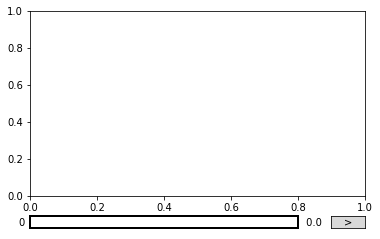

In [19]:
# errors:
outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[(zmin, zmax), (ymin, ymax), xdatacube], cmap='seismic_r')

# works:
# outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[(zmin, zmax), (ymin, ymax), (xminasnan, xmax)], cmap='seismic_r')
# outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[zlabels, ylabels, xlabels], cmap='seismic_r')
# outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[zlabels, (ymin, ymax), (xmin, xmax)], cmap='seismic_r')
# outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[zlabels, (ymin * np.pi, ymax* np.pi), (xmin* np.pi, xmax* np.pi)], cmap='seismic_r')
# outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[zlabels, (ymin * 10^12, ymax * 10^12), (xmin * 10^12, xmax * 10^12)], cmap='seismic_r')
# outanimation = imageanimator.ImageAnimator(data_cube, axis_ranges=[(zmin, zmax), (ymin, ymax), (xmin, xmax)], cmap='seismic_r')